# 4G7 Coding Assignment 1 - 5622B

Import the code I have written and relevant packages

In [34]:
from chemotaxis import Chemotaxis
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model

Given the assumptions and the model in the assignment sheet:

$\lambda (s) = \frac{A_{max} - A_{min}}{1 + exp(ks)} + A_{min}$ and $\tau_s \dot{s} = -s+\Delta c$

s can be viewed as a response of the cell (system) to the concentration gradient. This has a very common form $T\dot{y} + y = x$ (e.g., spring damper system). 

But to run simulation, we use a simple Euler integration to approach this: $s_{n+1} = s_n + dt \dot{s} = s_n + dt\frac{-s_n + \Delta c(x_n, x_{n-1})}{\tau_s}$ where $\Delta c$ is a function of current and prvious cell position. 

Initialise the coeficient and parameters we are going to use in the simulation, and because we are running the simulation in discrete spatial and temporal space:
- velocity takes one unit position step in one unit time step.
- the fixed timestep is 1 unit.
- the initial direction of the cell is positive, once tumble happens the sign is reversed
- initial position of the cell is 0
- initial value of s in the Euler integration is set to 0 (do not sense a gradient, explained later)
- $A_{max}$ and $k$ are set to 0.25 and 1 respectively for reasons we will see later.
- $A_{max}$ may also be set to 1 for convenience of calculation later on.

Some values are set this way to facilitate simulation, we can give them unit for example E. coli:
- est. velocity = 21.2 $\mu m/s$
- dt should be a reaonable value such that, the probability of tumbling is the cumulative exponential distribution of dt. Although this value is also varied by gradient concentration, we may assign $p_t$ probability of tumbling wituout present concentration gradient. Therefore, $p_t =$ cumulative exponential distribution evaluated at dt. As we will see later this is why the choice of $A_{max}$ and $A_{min}$ is affected by dt. If we want to capture more tumbling i.e. longer simulation, with less computational steps, the A values can be set higher and therefore dt will be higher as well. But there is a limit such that we cannot have multiple tumbling in a single timestep, so the probability of more than two events in given time dt should be negligible (from Poisson). Typically in E. coli dt can be set to $-ln(1 - p_t) = ln(8/7) \approx 0.134 \text{ s if } p_t = 0.125$ (from cumulative exponential distribution) because mean run time is around 1 s and the probability of two tumbling happening in this timestep is 7.8e-3 (from Poisson). This calculation is just an estimation because the distribution of the run time is assumed unknown.
- a unit step is then around 2.8 $\mu m$

In [35]:
parameters = {'velocity' : 1, 'dt' : 1, 'direction' : 1, 'x' : 0, 's' : 0, 'maxA' : 0.25, 'k' : 1}

The choice of $A_{max}$ and $k$ can be justified by plotting the function $\lambda(s)$ with two adjustable slide bar for $A_{max}$ and $k$ in Supplementary Notebook 1. It is directly visual that this function is a modified sigmoid function (very close form to a logistic function). The $A_{max}$ controls the maximum saturation i.e. maximum probability of tumbling when signal is extreme, and $k$ controls the steepness i.e. how confident the cell is about the signal. We can also see what $A_{min}$ means (mininum saturation) but we will examine its influence in the simulation instead.

## Flat Concentration Distribution
Concentration gradient remains zero everywhere

In [36]:
parameters['cType'] = "flat"

In [37]:
exp1 = Chemotaxis(**parameters)

Firstly let us plot 10 simulation of flat concentration for 1000 steps. The parameters are set to $A_{min} = 0$ and $\tau_s = 1$

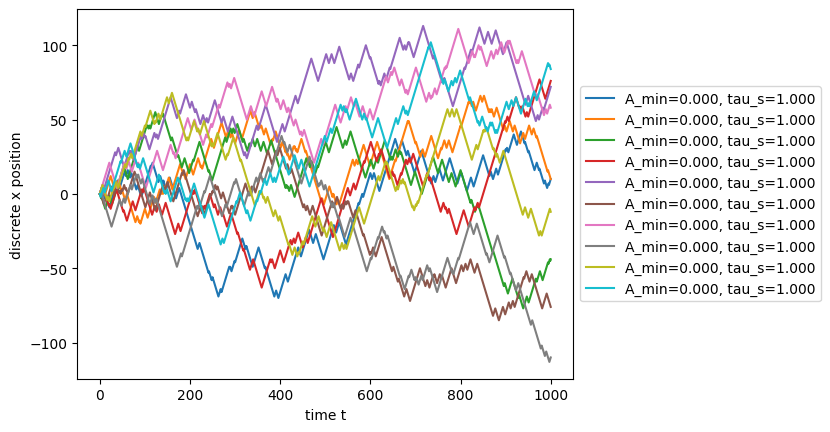

In [39]:
%autoreload
N = 10
A_min = [0] * N
tau_s = [1] * N
traj1 = exp1.plt_multiple_traj(N, A_min, tau_s, no_steps=1000)

Varying $\tau_s$ to see its effect on the samples.

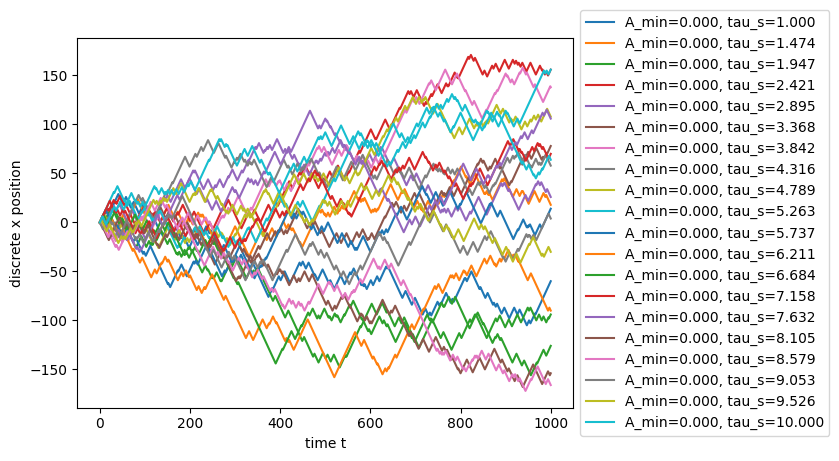

In [40]:
%autoreload
N = 20
A_min = [0] * N
tau_s = [i for i in np.linspace(1, 10, N)]
traj1 = exp1.plt_multiple_traj(N, A_min, tau_s, no_steps=1000)

It seems that $\tau_s$ plays no significant role when the concentration gradient is zero. In fact by inspecting the formula above, if s is initialised to be 0, then s will remain 0 throughout the simulation. And if s is set to a non-zero value (10 in example below), it will still gradually converge to zero $s_{n+1} = s_n(1 - 1/\tau_s)$, the convergence rate of which will depend on $\tau_s$ (larger value gives slower convergence).

We can see the change in s for different value of $\tau_s$.

In [41]:
%autoreload
parameters['s'] = 10
exp1_1 = Chemotaxis(**parameters)
exp1_1.run_simulation(0, 10, no_steps=20, plot=False)
print("for tau = 10")
[print('%.3f' % i, end=' ') for i in exp1_1.s_list]
print("\n")
exp1_1.run_simulation(0, 2, no_steps=20, plot=False)
print("for tau = 2")
[print('%.3f' % j, end=' ') for j in exp1_1.s_list]
print(" ")

for tau = 10
10.000 9.000 8.100 7.290 6.561 5.905 5.314 4.783 4.305 3.874 3.487 3.138 2.824 2.542 2.288 2.059 1.853 1.668 1.501 1.351 1.216 

for tau = 2
10.000 5.000 2.500 1.250 0.625 0.312 0.156 0.078 0.039 0.020 0.010 0.005 0.002 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000  


From the above arguments, we can deduce that one of the possible intepretations of $\tau_s$ is how fast the cell detects or senses the change in the environment, when it is set to $dt = 1$, $s_{n+1}$ will just be $\Delta c$ at step n. The role of s is also hinted in this explaination - it is the signal sensing by the cell. This means s is responding to concentration gradient with a time constance. As we saw earlier in the supplementary notebook 1, the probability of tumbling is larger than $A_{avg} = (A_{max} + A_{min})/2$ when s is negative and smaller than $A_{avg}$ when s is positive. Therefore, when the cell senses a positive gradient, s, it is more likely to not tumble and when the cell senses a negative gradient, the probability of tumbling increases. 

The previous setting assumes that we want $A_{avg} = 0.125$. This may be changed if we want to encourage tumbling to improve average population fitness (more frequent tumbling) or just run simulation longer in time with fewer computational steps.

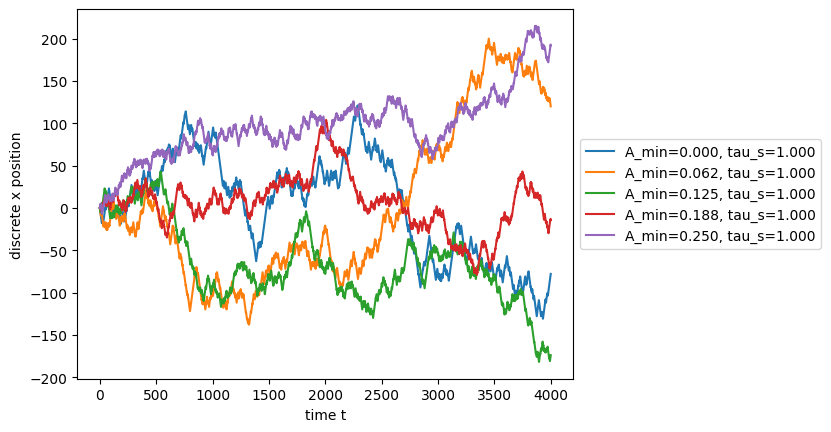

In [11]:
%autoreload
N = 5
A_min = [i for i in np.linspace(0, 0.25, N)]
tau_s = [1] * N
traj1 = exp1.plt_multiple_traj(N, A_min, tau_s, no_steps=4000)

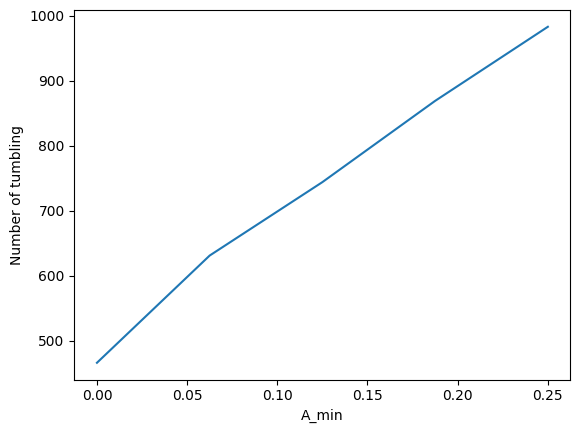

In [12]:
plt.plot(A_min, exp1.num_tumbles)
plt.ylabel("Number of tumbling")
plt.xlabel("A_min")
plt.show()

We can see from the above plot that larger $A_{min}$ (larger $A_{avg}$) has a lot more tumbling events for the same simulation length.

And in the setting below the probability of tumbling (reverse direction) is 0.75 throughout the simulation because $A_{max} = A_{min} = 0.25$.

In [15]:
%autoreload
# if A_min = A_max
traj1 = exp1.run_simulation(0.25, 1, no_steps=1000, plot=False)
print(f"Throughout the simulation there are {len(exp1.tumble_ps)} recorded tumble probability values for all timesteps")
print(f"The maximum value is {max(exp1.tumble_ps)}")
print(f"The minimum value is {min(exp1.tumble_ps)}")

Throughout the simulation there are 1000 recorded tumble probability values for all timesteps
The maximum value is 0.25
The minimum value is 0.25


## Linear Concentration Distribution
Concentration increases 1 unit per discrete step in space

In [16]:
parameters = {'velocity' : 1, 'dt' : 1, 'direction' : 1, 'x' : 0, 's' : 0, 'maxA' : 0.25, 
              'k' : 1, 'cType' : "linear"}
exp2 = Chemotaxis(**parameters)

Because s is initialised at 0. The time constant $\tau_s$ weights the history of the cells sensing to decide the frequency of the tumble. It is important to note that the cell does not know whether it has tumbled or not which means the signal recieved when it is travelling in the 'wrong' direction is also included in the history. One way of thinking about this is that how long the cell is taking to 'realise' the environment concentration, and if tumbling is happening too frequently the cell with long $\tau_s$ would not adapt nicely. When it is set to one, the cell will decide using the current concentration gradient only. To see the effect of this parameter, a longer simulation might be required.

In [18]:
%autoreload
exp2_1 = Chemotaxis(**parameters)
exp2_1.run_simulation(0, 10, no_steps=20, plot=False)
print("s for tau = 10")
[print('%.3f' % i, end=' ') for i in exp2_1.s_list]
print("\n")
exp2_1.run_simulation(0, 1, no_steps=20, plot=False)
print("s for tau = 1")
[print('%.3f' % j, end=' ') for j in exp2_1.s_list]
print(" ")

s for tau = 10
0.000 0.000 0.100 0.190 0.271 0.344 0.410 0.469 0.522 0.570 0.613 0.451 0.306 0.176 0.258 0.332 0.399 0.459 0.313 0.182 0.064 

s for tau = 1
0.000 0.000 1.000 1.000 1.000 1.000 1.000 1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000  


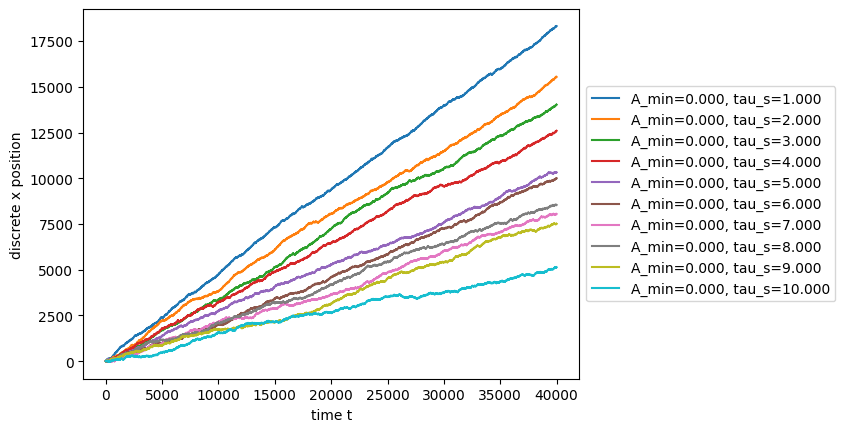

In [26]:
%autoreload
N = 10
A_min = [0] * N
tau_s = [i for i in np.linspace(1, 10, N)]
traj2 = exp2.plt_multiple_traj(N, A_min, tau_s, no_steps=40000)

This matches our earlier explaination of how fast the cells respond and hence drift to higher concentration. It is also possible that this indicates the rate of drifting to some extend. 

To look at the bulk behaviour, we plot the average end position of several simulations at different settings of $\tau_s$ - the relationship is not linear

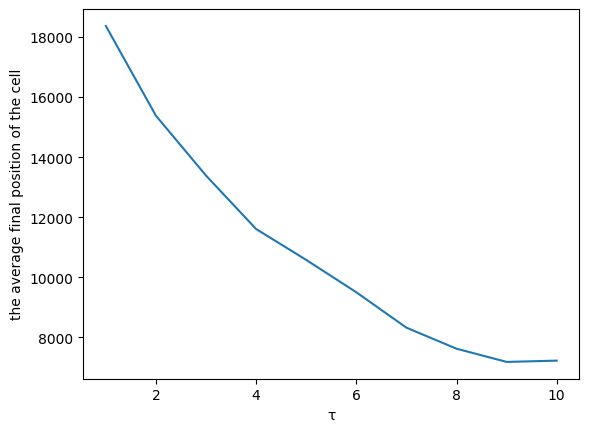

In [33]:
%autoreload
N = 10
repeat = 10
A_min = [0] * N
tau_s = [i for i in np.linspace(1, 10, N)]
traj2 = exp2.plt_multiple_traj(N * repeat, A_min * repeat, tau_s * repeat, no_steps=40000, plot=False)

end = []
tumble = []
for t in range(N):
    end.append(np.mean([exp2.end_x[t + N * n] for n in range(5)]))
    tumble.append(np.mean([exp2.num_tumbles[t + N * n] for n in range(5)]))
plt.plot(tau_s, end) 
plt.ylabel("the average final position of the cell")
plt.xlabel("τ")
plt.show()

The values of A controls the significance of diffusion term against the drifting term. When $A_{min}$ is set to a high value, the tumbling frequency is high and there is a smaller difference in the probabilities of tumbling when the cell is travelling in opposite directions. If the concentration gradient is noisy, the smaller tumbling frequency may be desired so that a longer mean run duration is achieved. 

In [ ]:
%autoreload
N = 10
A_min = [i for i in np.linspace(0, 0.25, N)]
tau_s = [2] * N
traj2 = exp2.plt_multiple_traj(N, A_min, tau_s, no_steps=4000)

## Drift and Diffusion Constants 
Idealy we want to solve our model analytically

Firstly, let us take a guess from previous analysis. The drift velocity constant should depend on the sensing of the cells and therefore depends on the values in tumbling probability such as $\tau$ and k. The diffusion constant should depend on the step length and run velocity but might not depend on parameters in the tumbling probability other than the A values (e.g., if the value of $A_{avg}$). 

To make calculation easier, the parameters are set as shown below with the cost of a few assumptions:
- Only one tumbling can happen during 1 timestep.
- The unit timestep is the average value of cell run time, e.g. 1 s. And unit step is then the typical run length, e.g. 21.2 $\mu m$.
- The cell directly respond to the concentration gradient, so it does not refer back to its previously sensed signal. 

In [96]:
parameters = {'velocity' : 1, 'dt' : 1, 'direction' : 1, 'x' : 0, 's' : 0, 'maxA' : 1, 
              'k' : 1, 'cType' : "linear"}
tau = 1
minA = 0

This allows analyse of 1D model for linear concentration as follows:

$\Delta_t p_x = L_{x+\Delta x}p_{x+\Delta x} - L_x p_x + R_{x-\Delta x}p_{x-\Delta x} - R_x p_x$ and $L_{x+\Delta x} = L_x$, $R_{x+\Delta x} = R_x$ for $\tau_s = 1$

$L = \lambda (+|\Delta c|) or 1 - \lambda (-|\Delta c|)$ depending on the current travelling direction of the cells. But since $(A_{max} + A_{min}) / 2 = 0.5$ these two values are the same.

Therefore, $\Delta_t p_x = 0.5 [(p_{x+\Delta x} - p_x) - (p_x - p_{x-\Delta x})] + (0.5 - \lambda (+|\Delta c|))(p_{x-\Delta x} - p_{x+\Delta x})$

$= 0.5 \Delta_x(\Delta_x p_x) - 0.46 \Delta_x p_x$ for unit concentration gradient $|\Delta c| = 1$

Divide both side by timestep and take limit gives $\frac{\partial p}{\partial t} = 0.5 \times lim(\frac{(\Delta x)^2}{\Delta t}) \times \frac{\partial^2 p}{\partial x^2} - 0.46 \times lim(\frac{\Delta x}{\Delta t}) \times \frac{\partial p}{\partial x}$. The second limit is just the velocity in our simulation. The first limit is more difficult to find out.

For the flat concentration case, we can simply discard the drift term and keep the diffusion term. 

To check the values in our simulation (essentially an impulse response), we look at the change in mean and variance of the Gaussian distribution.

Additionaly, we can look at a more detailed model: velocity jump process which contains two terms we already have - tumbling rate, $\lambda$ and velocity, s. [1]

From this model the estimated diffusion constant is then $D = s^2/\lambda$. Since the $\lambda$ in our model is changing with the concentration the diffusion constant will actually depend on parameters such as $\tau_s$ which varies controls the rate of tumbling per unit time. 

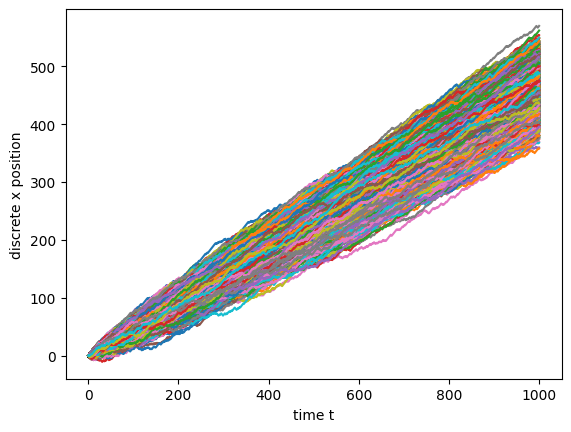

In [97]:
exp3 = Chemotaxis(**parameters)
%autoreload
N = 8000
A_min = [minA] * N
tau_s = [tau] * N
traj3 = exp3.plt_multiple_traj(N, A_min, tau_s, no_steps=1000, legend=False)

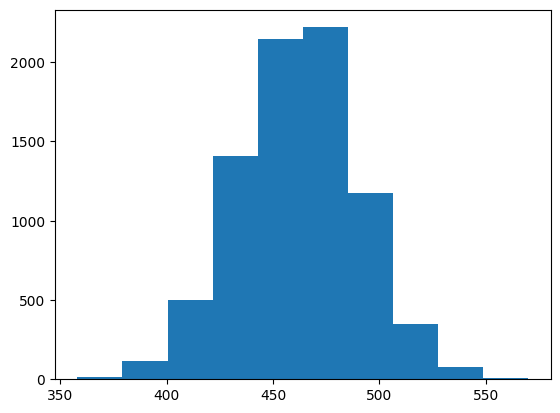

In [98]:
plt.hist(exp3.end_x)
plt.show()

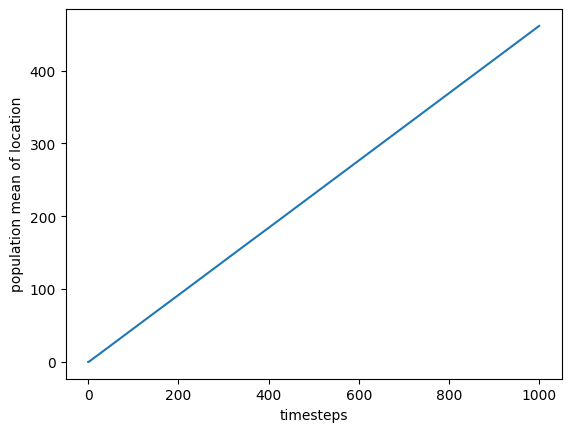

The velocity of the mean moving is 0.4579912884445206 which matches with the velocity constant we just calculated nicely: 0.46


In [99]:
traj3 = np.array(traj3)
population_mean3 = np.average(traj3, axis=0)
t = [i for i in range(len(traj3[0]))]
plt.plot(t, population_mean3)
plt.xlabel("timesteps")
plt.ylabel("population mean of location")
plt.show()
print(f"The velocity of the mean moving is {np.mean(population_mean3[1:]/t[1:])} which matches nicely with the velocity constant we just calculated: 0.46")

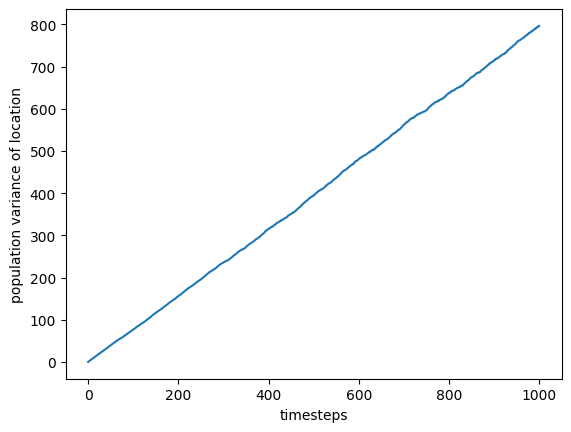

The velocity of the variance expanding is 0.7900794692292887 which matches loosely with the diffusion constant: var = 2Dt ≈ 1


In [105]:
traj3 = np.array(traj3)
population_var3 = np.var(traj3, axis=0)
t = [i for i in range(len(traj3[0]))]
plt.plot(t, population_var3)
plt.xlabel("timesteps")
plt.ylabel("population variance of location")
plt.show()
print(r"The velocity of the variance expanding is {} which matches loosely with the diffusion constant: var = 2Dt ≈ 1".format(np.mean(population_var3[1:]/t[1:])))

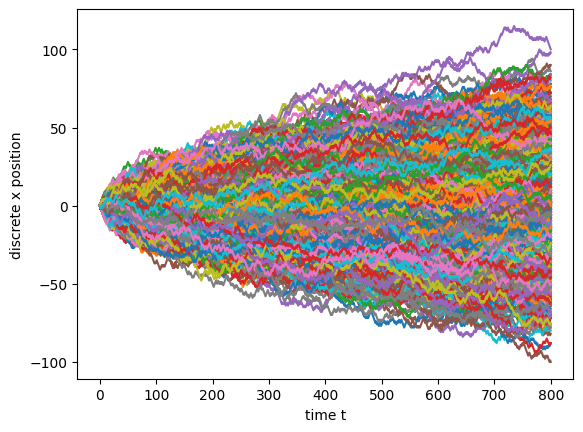

In [110]:
parameters = {'velocity' : 1, 'dt' : 1, 'direction' : 1, 'x' : 0, 's' : 0, 'maxA' : 1, 
              'k' : 1, 'cType' : "flat"}
tau = 1
minA = 0
exp4 = Chemotaxis(**parameters)
N = 2500
A_min = [minA] * N
tau_s = [tau] * N
traj4 = exp4.plt_multiple_traj(N, A_min, tau_s, no_steps=800, legend=False)

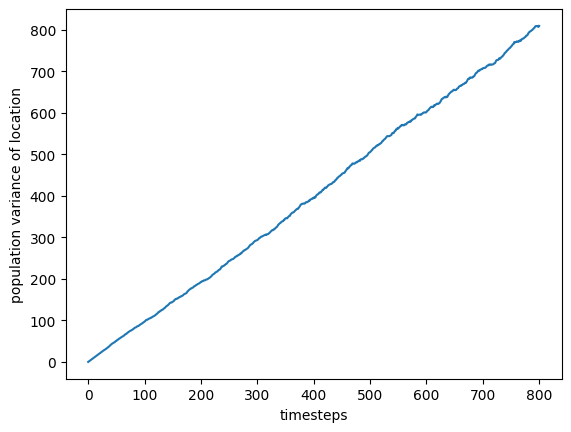

The velocity of the variance expanding is 0.9923331909181151 which matches nicely with the diffusion constant: var = 2Dt ≈ 1


In [111]:
traj4 = np.array(traj4)
population_var4 = np.var(traj4, axis=0)
t = [i for i in range(len(traj4[0]))]
plt.plot(t, population_var4)
plt.xlabel("timesteps")
plt.ylabel("population variance of location")
plt.show()
print(f"The velocity of the variance expanding is {np.mean(population_var4[1:]/t[1:])} which matches nicely with the diffusion constant: var = 2Dt ≈ 1")

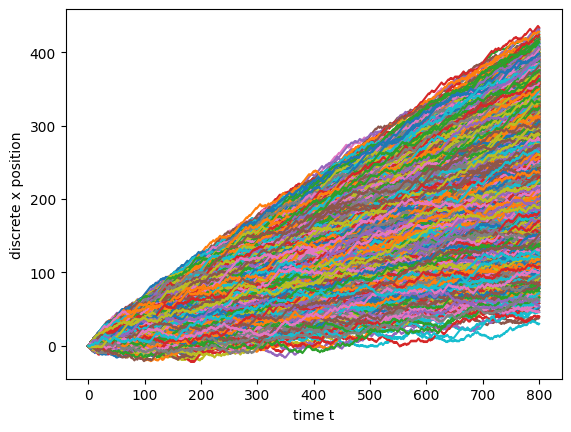

In [142]:
%autoreload
import copy
parameters = {'velocity' : 1, 'dt' : 1, 'direction' : 1, 'x' : 0, 's' : 0, 'maxA' : 1, 
              'k' : 1, 'cType' : "linear"}

tau = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.75, 2, 2.5, 3, 3.5]
minA = 0
N = 500
A_min = [minA] * N
exp5_list = []
traj5_list = []

for t in tau:
    tau_s = [t] * N
    exp5 = Chemotaxis(**parameters)
    traj5 = exp5.plt_multiple_traj(N, A_min, tau_s, no_steps=800, legend=False)
    exp5_list.append(copy.deepcopy(exp5))
    traj5_list.append(copy.deepcopy(traj5))

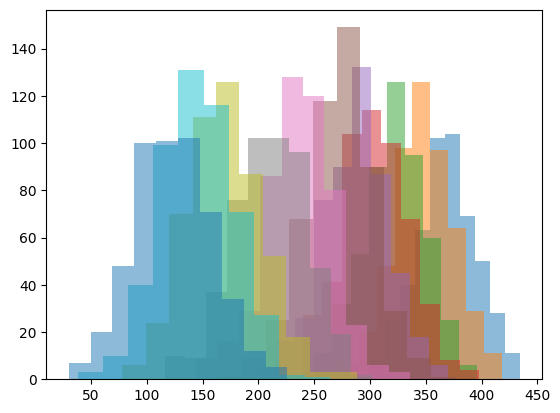

In [143]:
for e in exp5_list:
    plt.hist(e.end_x, alpha=0.5)
plt.show()

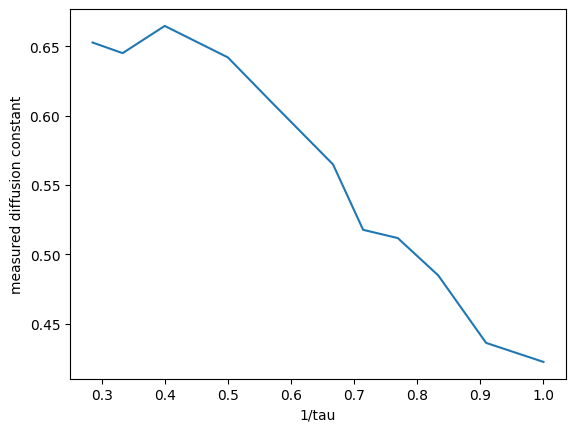

In [157]:
D = []
for t, traj in zip(tau, traj5_list):
    traj = np.array(traj)
    population_var = np.var(traj, axis=0)
    time = [i for i in range(len(traj[0]))]
#     plt.plot(time, population_var, label=f"tau = {t}")
#     plt.xlabel("timesteps")
#     plt.ylabel("population variance of location")
#     print(f"The velocity of the variance expanding is {np.mean(population_var[1:]/time[1:])}")
    D.append(np.mean(population_var[1:]/time[1:]) / 2)
plt.plot(1/np.array(tau), D)
plt.xlabel("1/tau")
plt.ylabel("measured diffusion constant")
# plt.legend()
plt.show()

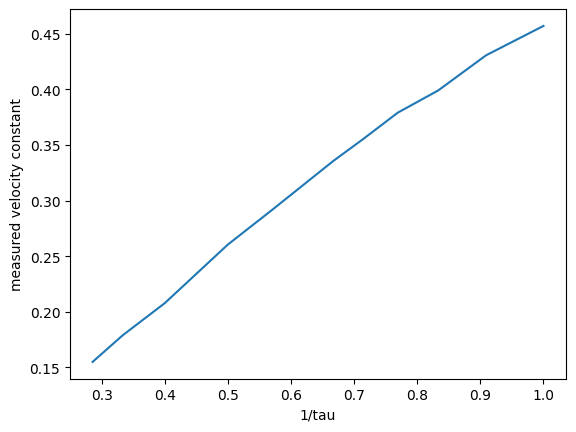

In [151]:
v = []
for t, traj in zip(tau, traj5_list):
    traj = np.array(traj)
    population_mean = np.average(traj, axis=0)
    time = [i for i in range(len(traj[0]))]
    v.append(np.mean(population_mean[1:]/time[1:]))
plt.plot(1/np.array(tau), v)
plt.xlabel("1/tau")
plt.ylabel("measured velocity constant")
plt.show()

It is shown that $\tau_s$ has effect on both diffusion and drift constant, where possibly drift constant is $\propto 1/\tau_s$ and diffusion constant is $\propto -1/\tau_s$

What are the limitations to this model?
- time scale must be short
- the time taken for doing tumbling is not captured, we can add a tumbling time in the simulation (would be more useful in 2D case).
- this does not capture cell-to-cell variation, we can add some stochasticity in the parameters
- the diffusion constant is influenced by the presence of concentration gradient because tumbling probability is large enough such that multiple tumbling might be possible in dt (fixed value during simulation). This may be one of the reason why the diffusion constant from linear concentration is not very good match with our prediction.

## Reference
[1] Othmer, H.G., Dunbar, S.R. & Alt, W. Models of dispersal in biological systems. J. Math. Biology 26, 263–298 (1988). https://doi.org/10.1007/BF00277392